# Compositional analysis Total data

In [1]:
import scanpy as sc
from tidyverse.dummy import *
from sctools import pipeline
from sctools.scplotting import kneeplot_split, recolor
from sctools.de import gene_expression_to_flat_df_NEW, scanpy_DE_to_dataframe_fast, get_de_genes
from crukiopy_release.datatools import read_metadata, fix_diagnosis, diagnosis_fix_dict
from crukiopy_release.colormaps import celltype_order_coarse_celltype, color_dict_diagnosis, cmap_subtypes, color_dict_coarse_celltype
import scHCLpy.adata
import gc
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
from sccoda.util import comp_ana as mod
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg')
from crukiopy_release.celltype_mappings import annotate_coarse_celltype, annotate_epi_stroma_immune

Importing tidyverse


In [2]:
adata = sc.read_h5ad('/home/mstrasse/TB4/Aug2022_adata/Atlas/Eso_Atlas.h5ad')

# Stringent filtering!!
adata = adata[adata.obs.doublet_score<0.2]
# adata = adata[adata.obs.doublet_score<0.1]
adata = adata[adata.obs.percent_mito<0.1]

# fixing some diagnosis
adata = fix_diagnosis(adata)

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Trying to set attribute `.obs` of view, copying.


In [3]:
df_meta = read_metadata()

# again fix diagnosis in those samples
df_meta = df_meta[df_meta.samplename.isin(adata.obs.samplename.unique())].set_index('samplename').sort_values('diagnosis')
for s, d in diagnosis_fix_dict.items():
    if s in df_meta.index:
        df_meta.loc[s, 'diagnosis'] = d

In [4]:
adata.obs['tissue_split'] = annotate_epi_stroma_immune(adata, cluster_field='leiden')
adata.obs['tissue_split'] = pd.Categorical(adata.obs['tissue_split'])

In [ ]:
# annotating broad cell types 

In [5]:
adata.obs['celltype_split'] = annotate_coarse_celltype(adata, cluster_field='leiden')
adata.obs['celltype_split'] = adata.obs['celltype_split'].astype(str)

adata.obs.loc[adata.obs.celltype_split=="Epithelial cells",'celltype_split'] = 'Columnar Epithelium'
adata.obs.loc[adata.obs.celltype_split=="Macrophages",'celltype_split'] = 'Myeloid'
adata.obs.loc[adata.obs.leiden.isin(['20','18','17']),'celltype_split'] = 'Squamous Epithelium'
adata.obs.loc[adata.obs.leiden=="13", 'celltype_split'] = 'Myofibroblasts'

adata.obs['celltype_split'] = pd.Categorical(adata.obs['celltype_split'])

color_dict_coarse_celltype['Columnar Epithelium'] = color_dict_coarse_celltype['Epithelial cells']
color_dict_coarse_celltype['Squamous Epithelium'] = '#025b02'
color_dict_coarse_celltype['Myeloid'] = color_dict_coarse_celltype['Macrophages']
color_dict_coarse_celltype['Myofibroblasts'] = '#005eb7'
color_dict_coarse_celltype['Mast cells'] = '#b95657'
recolor(adata, 'celltype_split', color_dict_coarse_celltype)

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'diagnosis' as categorical
... storing 'sample_diagnosis' as categorical


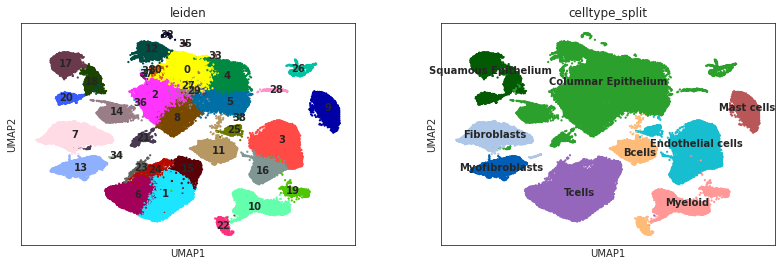

In [6]:
set_matplotlib_formats('png')
sc.pl.umap(adata, color=['leiden', 'celltype_split'], legend_loc='on data', size=20)

# Clustering samples based on cell type composition

In [7]:
cluster_name = 'celltype_split'
a_tmp = adata

data_scanpy_1 = dat.from_scanpy(
    a_tmp,
    cell_type_identifier=cluster_name,
    sample_identifier="samplename",
    covariate_df=df_meta[df_meta.index.isin(a_tmp.obs.samplename.unique())]
)

In [8]:
diagnosis_ordered = ['NE', 'M','D','T', 'MDT', 'MT', 'DT', 'NS']

In [9]:
from crukiopy_release.colormaps import cmap_subtypes, ListedColormap

In [10]:
cluster_order = [
    'Columnar Epithelium', 
    'Squamous Epithelium',
    'Bcells', 
    'Tcells',
    'Mast cells', 
    'Myeloid',
    'Endothelial cells', 
    'Fibroblasts',
    'Myofibroblasts',
]

In [11]:
leiden_color_dict = dict(zip(data_scanpy_1.var.index, adata.uns[f'{cluster_name}_colors'] ))
cmap_reordered = ListedColormap([leiden_color_dict[c] for c in cluster_order])   

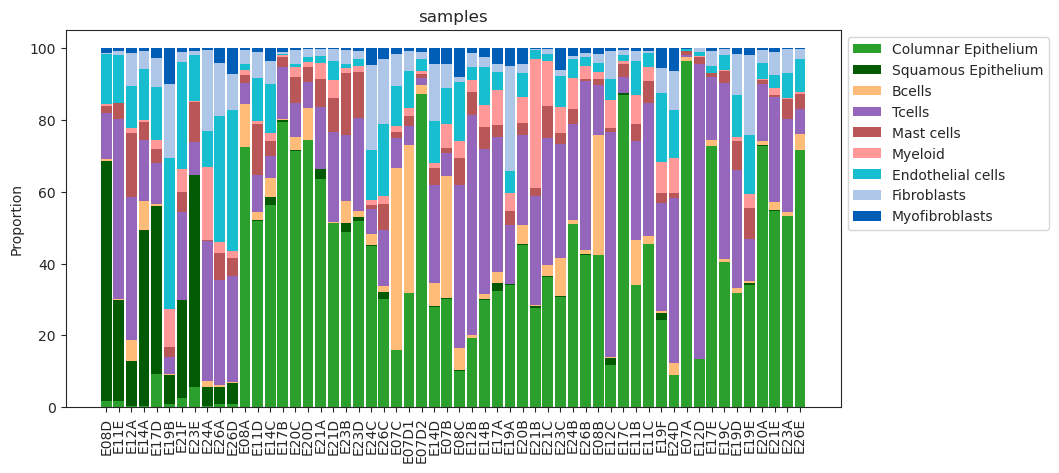

In [12]:
order = []
for d in diagnosis_ordered:
    order.extend(sorted(df_meta.query('diagnosis==@d').index))

set_matplotlib_formats('svg')
fig = viz.stacked_barplot(data_scanpy_1[:, cluster_order], feature_name="samples", figsize=(10,5), cmap=cmap_reordered, level_order=order)
plt.xticks(rotation=90);
set_matplotlib_formats('png')

# fig.figure.savefig(f'{plotfolder}/Tcell_proportions_per_sample.svg')

In [14]:
from sctools.composition import clustered_heatmap_from_sccoda_CLR

100%|██████████| 56/56 [00:00<00:00, 1586.18it/s]


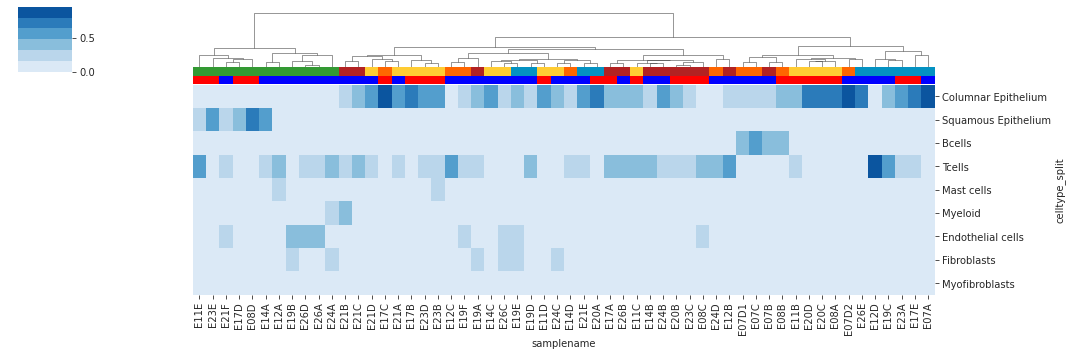

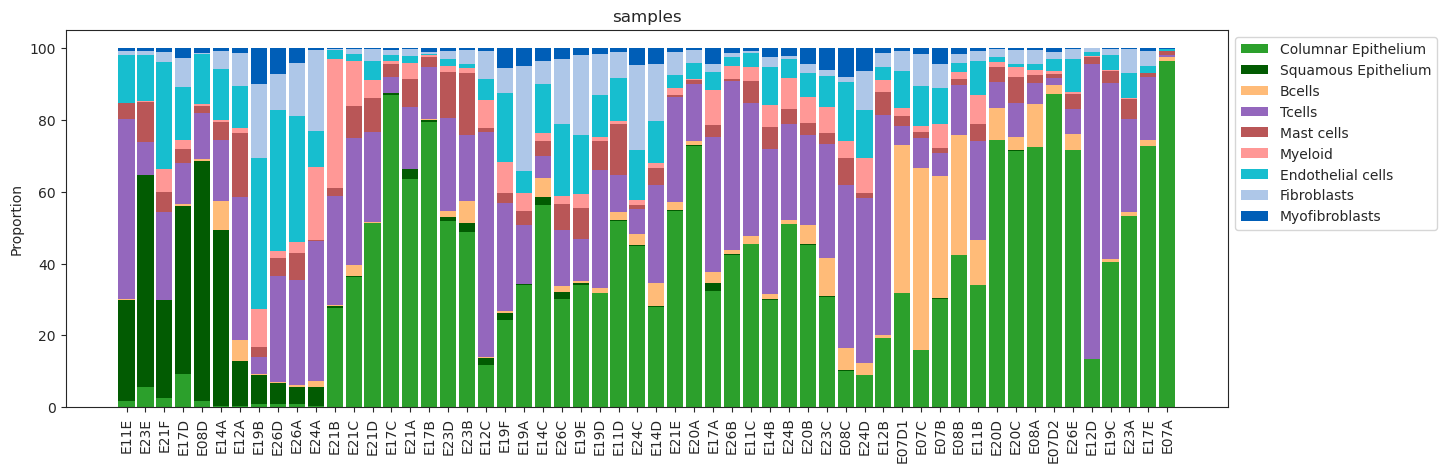

In [16]:
clustered_heatmap_from_sccoda_CLR(data_scanpy_1[:, cluster_order], barcolormap=cmap_reordered );